In [2]:
# This is a notebook to train and evaluate everything in one notebook

In [3]:
from sklearn.model_selection import train_test_split
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, BatchNormalization, Activation, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger, TensorBoard
from tensorflow import keras
import matplotlib.pyplot as plt
from PIL import ImageFilter, ImageEnhance
import random
import pandas as pd
import numpy as np
import json
import sys
sys.path.insert(0, '../shared/')
from predict import Predict

In [45]:
# Make sure the GPU is being used
gpu_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.get_device_details(gpu_devices[0])

2023-07-04 00:42:25.808239: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


{'compute_capability': (8, 9), 'device_name': 'NVIDIA GeForce RTX 4090'}

In [19]:
# Variables

# Specify the dataset path in dataset_path
# Dataset link: https://drive.google.com/file/d/1LBg92gxtyrHnsjSQ0XQBzSl8lupePIsJ/view?usp=sharing
dataset_path = "/mnt/e/Old Computer/COMP 597/Project/Dataset/"

fog_path = dataset_path + 'Fog/'
night_path = dataset_path + 'Night/'
rain_path = dataset_path + 'Rain/'
snow_path = dataset_path + 'Snow/'

# class_dict.csv path
classes_csv_path = "/mnt/e/Github/SemanticSegmentationOfLowVisibilityRoadways/segmentation/config/class_dict.csv"

image_size = (256, 256)

In [15]:
# How many validation images used to evaluate the model
# 100 validation images in total per condition
number_of_validation_images = 50

# Creates a list of paths to the images
fog_validation_rgb = list(Path(fog_path + 'RGB/Fog_Validation').glob('*.png'))[:number_of_validation_images]
fog_validation_annotated = list(Path(fog_path + 'Annotated/Validation').glob('*_gt_labelColor.png'))[:number_of_validation_images]
fog_training_rgb = list(Path(fog_path + 'RGB/Fog_Train').glob('*.png'))
fog_training_annotated = list(Path(fog_path + 'Annotated/Train').glob('*_gt_labelColor.png'))         


night_validation_rgb = list(Path(night_path + 'RGB/Night_Validation').glob('*.png'))[:number_of_validation_images]
night_validation_annotated = list(Path(night_path + 'Annotated/Validation').glob('*_gt_labelColor.png'))[:number_of_validation_images]
night_training_rgb = list(Path(night_path + 'RGB/Night_Train').glob('*.png'))
night_training_annotated = list(Path(night_path + 'Annotated/Train').glob('*_gt_labelColor.png'))


rain_validation_rgb = list(Path(rain_path + 'RGB/Rain_Validation').glob('*.png'))[:number_of_validation_images]
rain_validation_annotated = list(Path(rain_path + 'Annotated/Validation').glob('*_gt_labelColor.png'))[:number_of_validation_images]
rain_training_rgb = list(Path(rain_path + 'RGB/Rain_Train').glob('*.png'))
rain_training_annotated = list(Path(rain_path + 'Annotated/Train').glob('*_gt_labelColor.png'))


snow_validation_rgb = list(Path(snow_path + 'RGB/Snow_Validation').glob('*.png'))[:number_of_validation_images]
snow_validation_annotated = list(Path(snow_path + 'Annotated/Validation').glob('*_gt_labelColor.png'))[:number_of_validation_images]
snow_training_rgb = list(Path(snow_path + 'RGB/Snow_Train').glob('*.png'))
snow_training_annotated = list(Path(snow_path + 'Annotated/Train').glob('*_gt_labelColor.png'))

print('Fog Validation Size: ' + str(len(fog_validation_rgb)))
print('Night Validation Size: ' + str(len(night_validation_rgb)))
print('Rain Validation Size: ' + str(len(rain_validation_rgb)))
print('Snow Validation Size: ' + str(len(snow_validation_rgb)))

Fog Validation Size: 50
Night Validation Size: 50
Rain Validation Size: 50
Snow Validation Size: 50


In [16]:
# Creates a list of tuples containing matching paths -> [(RGB image path, ANNOTATED image path), (..., ...), ...]
fog_training_duo = [(x, y) for x, y in zip(fog_training_rgb, fog_training_annotated)]
fog_validation_duo = [(x, y) for x, y in zip(fog_validation_rgb, fog_validation_annotated)]

night_training_duo = [(x, y) for x, y in zip(night_training_rgb, night_training_annotated)]
night_validation_duo = [(x, y) for x, y in zip(night_validation_rgb, night_validation_annotated)]

rain_training_duo = [(x, y) for x, y in zip(rain_training_rgb, rain_training_annotated)]
rain_validation_duo = [(x, y) for x, y in zip(rain_validation_rgb, rain_validation_annotated)]

snow_training_duo = [(x, y) for x, y in zip(snow_training_rgb, snow_training_annotated)]
snow_validation_duo = [(x, y) for x, y in zip(snow_validation_rgb, snow_validation_annotated)]

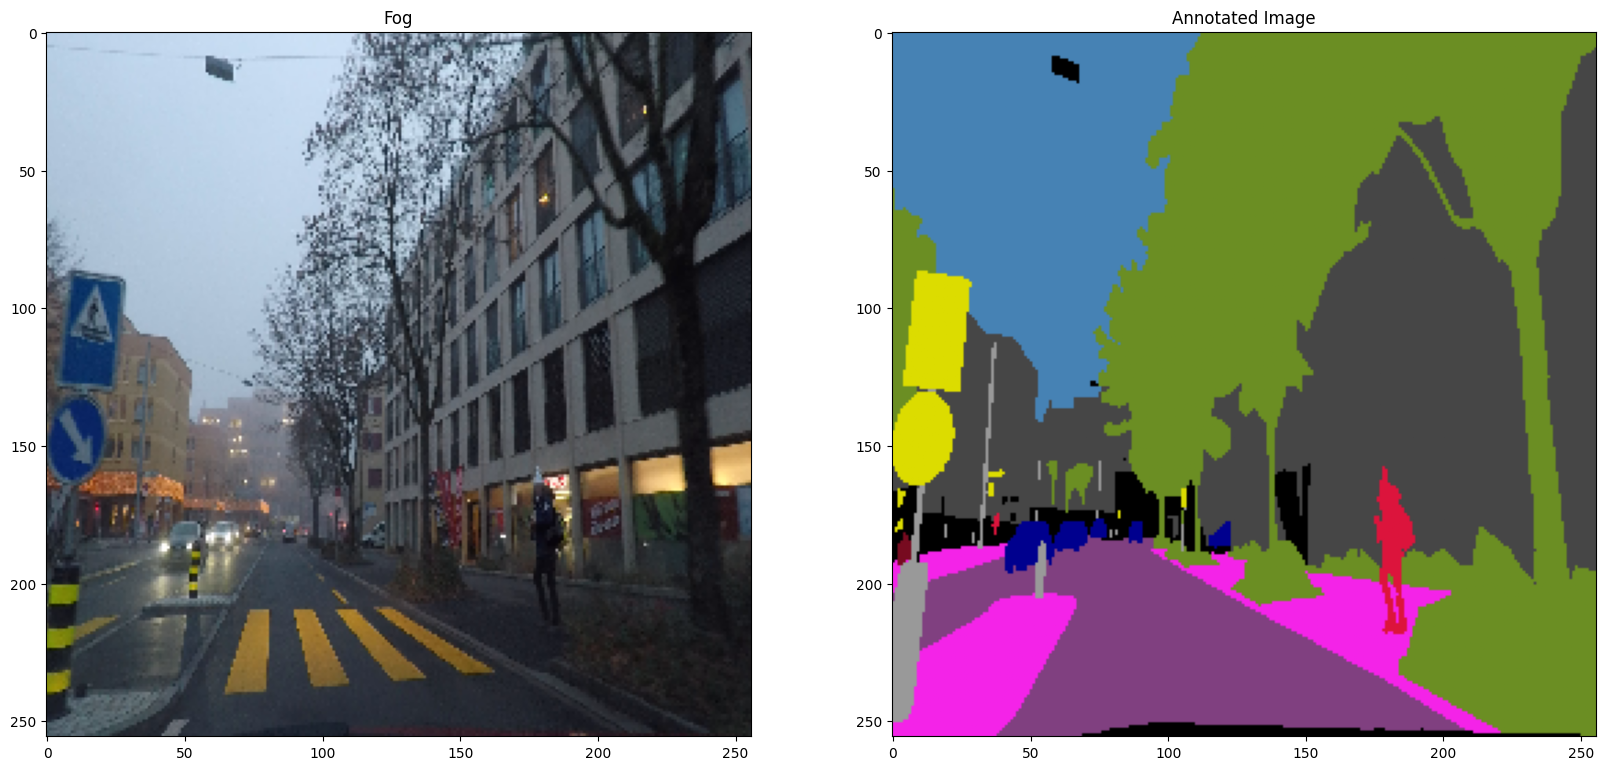

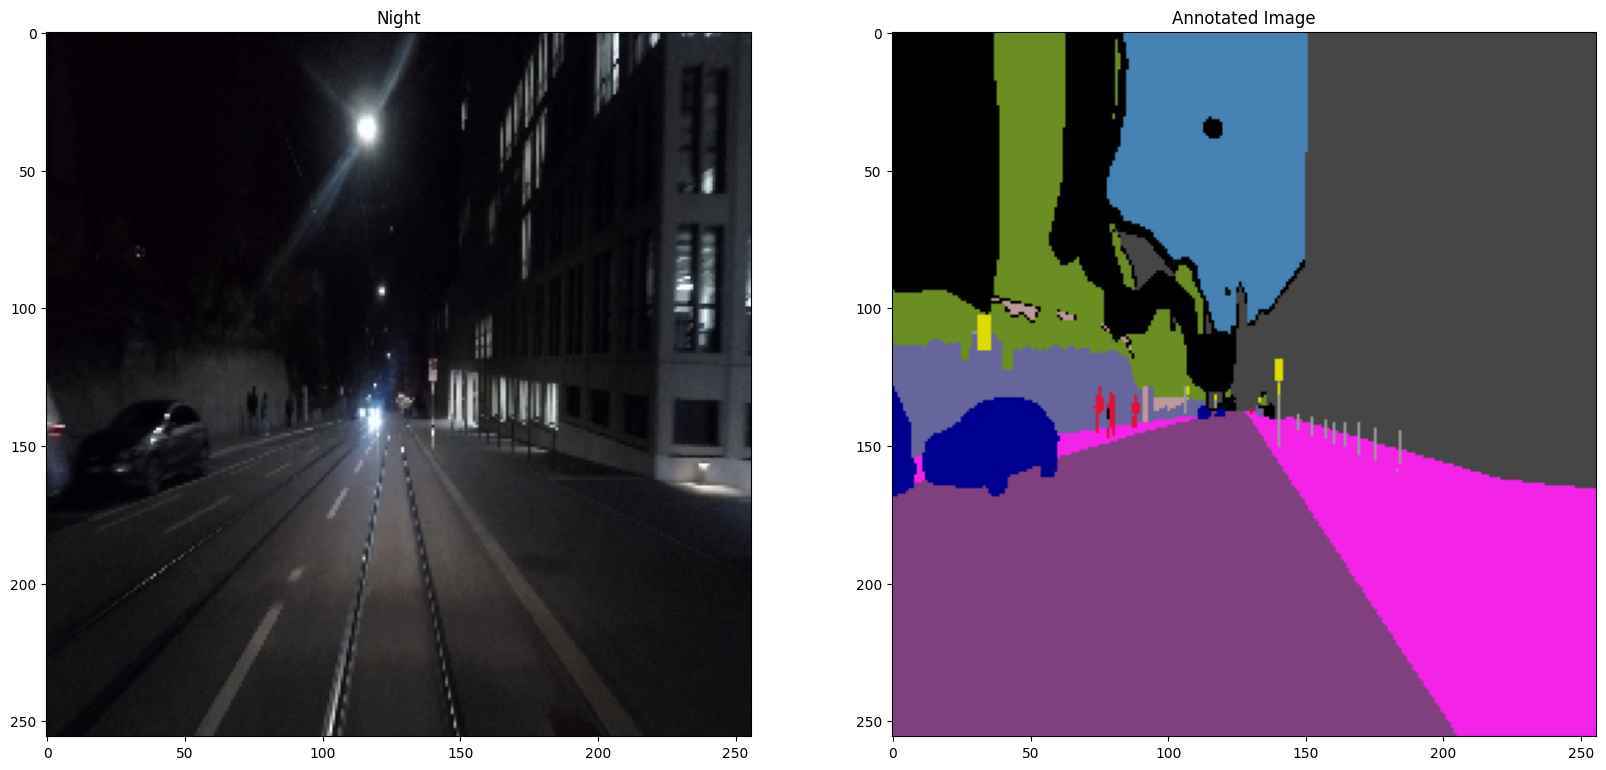

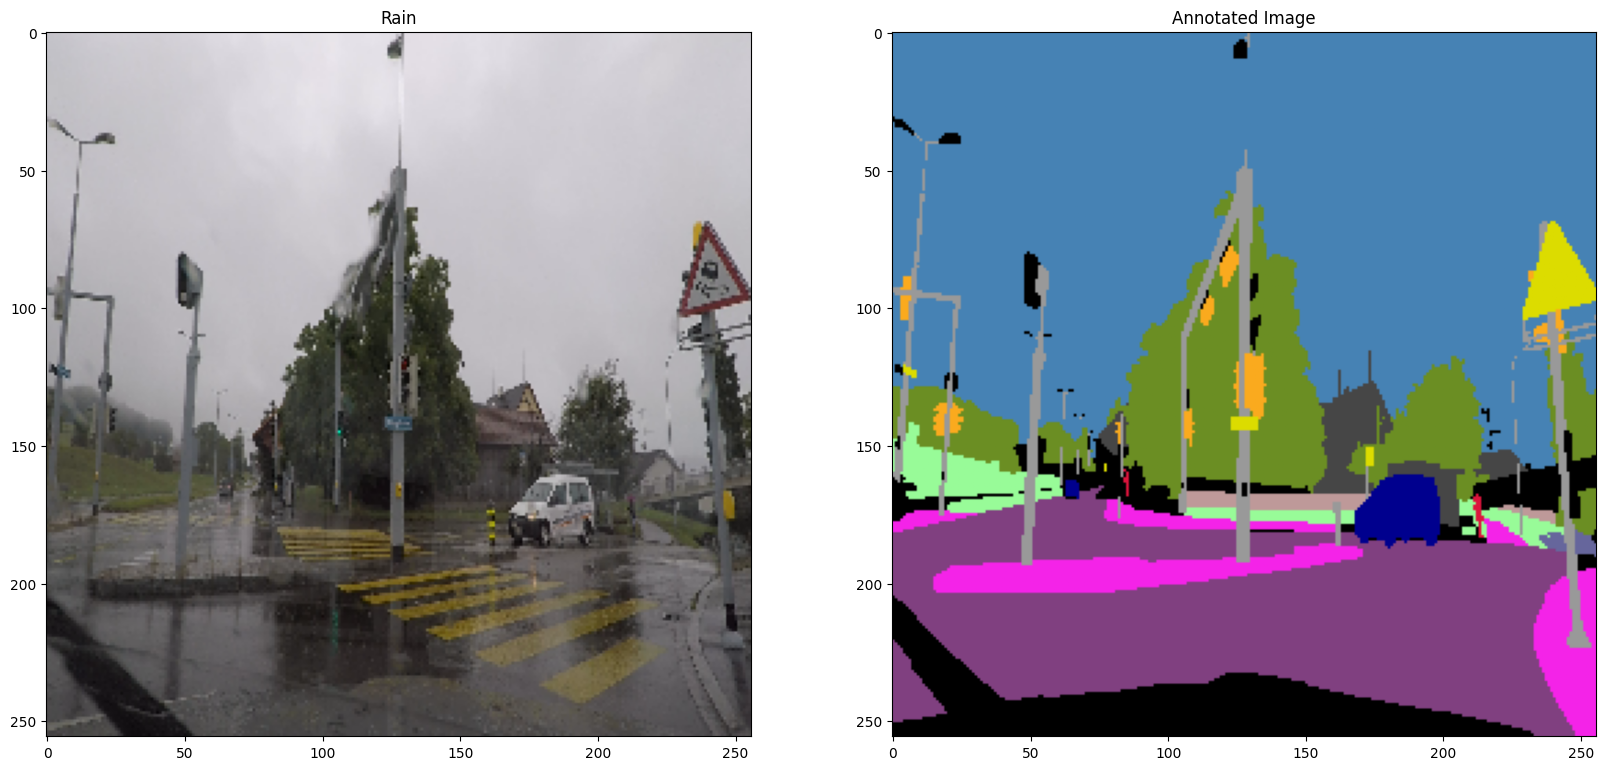

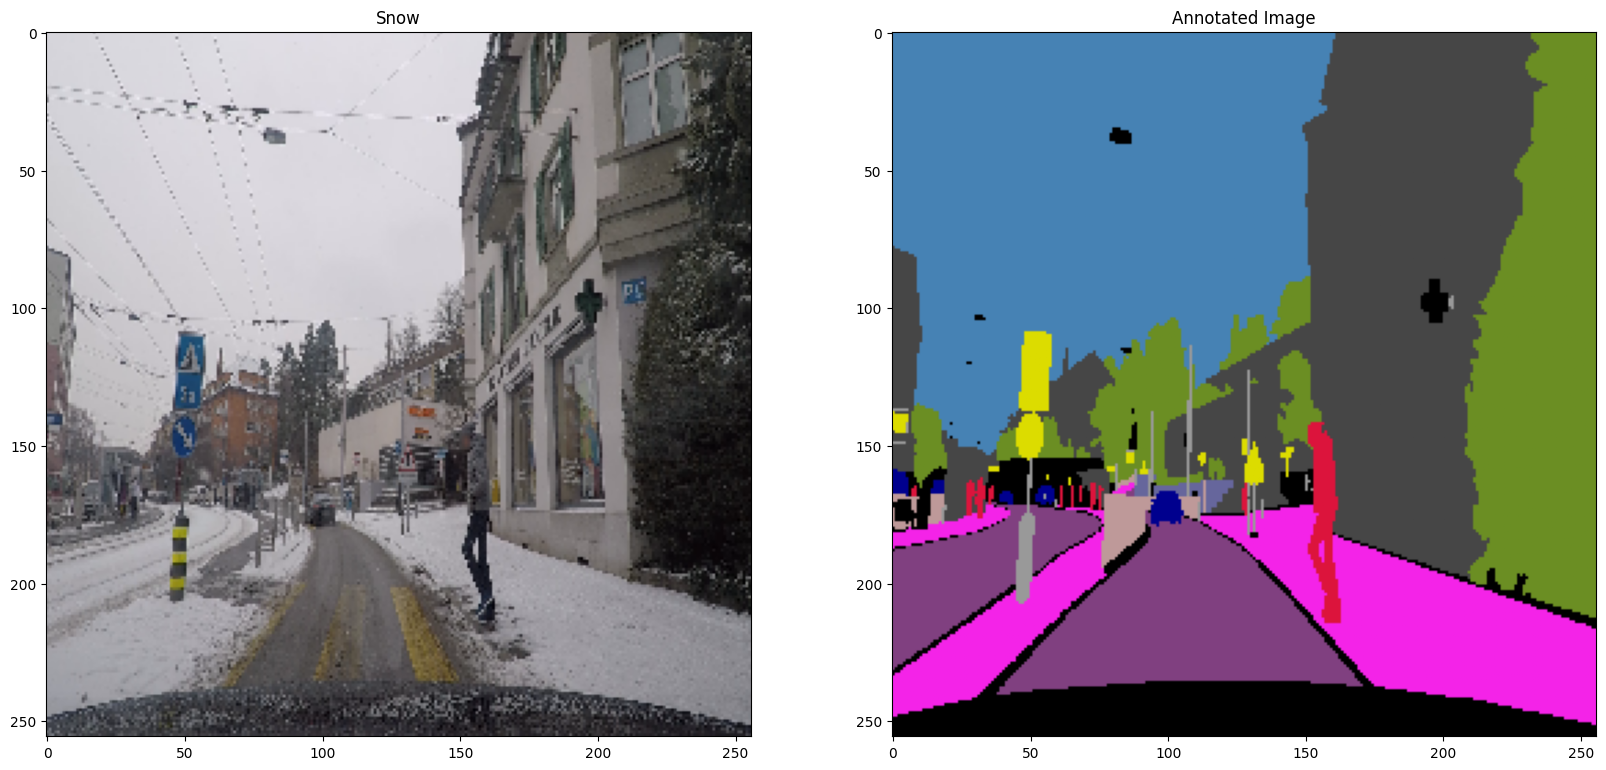

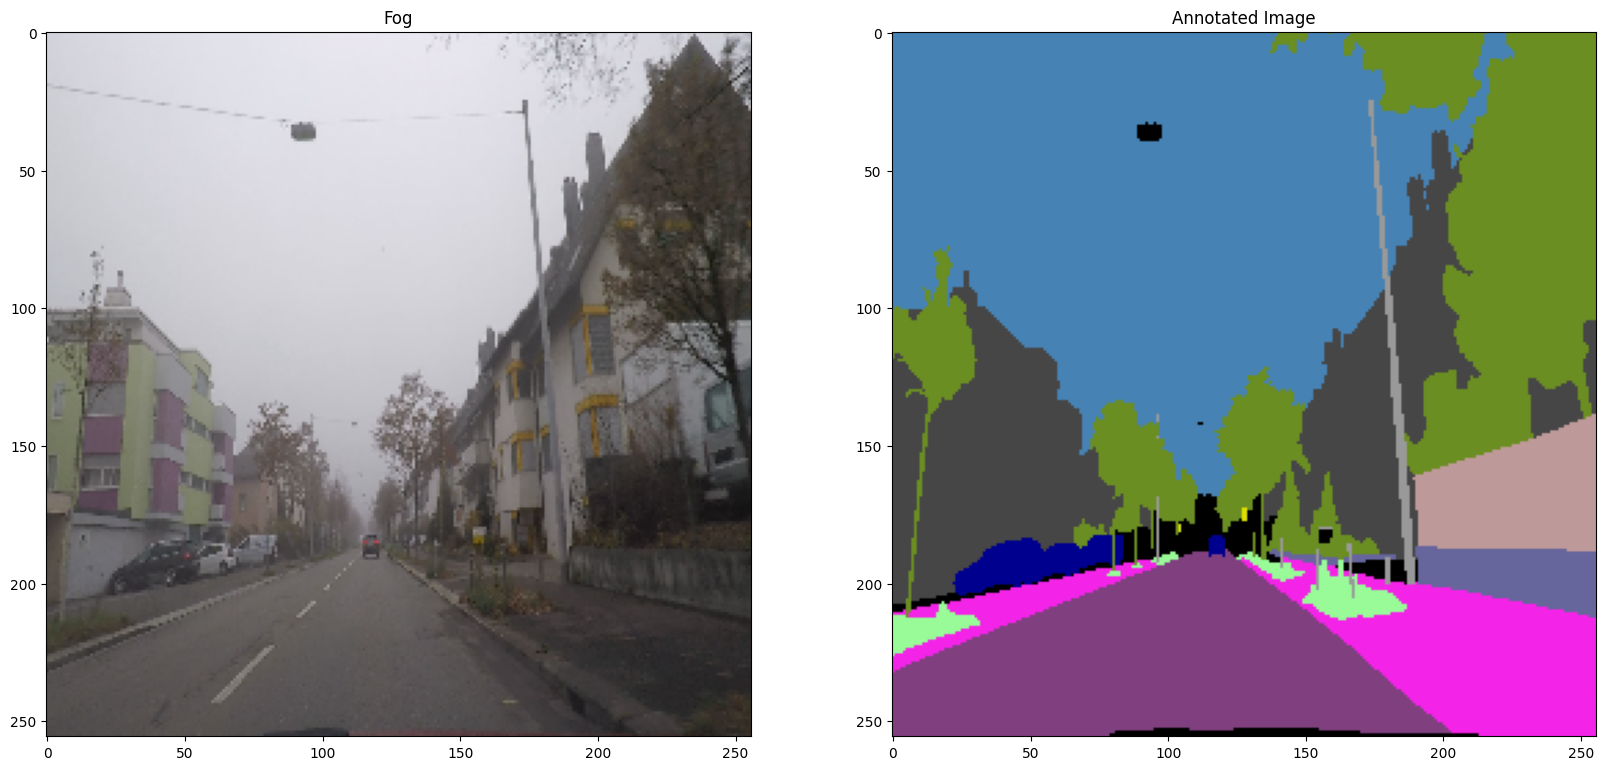

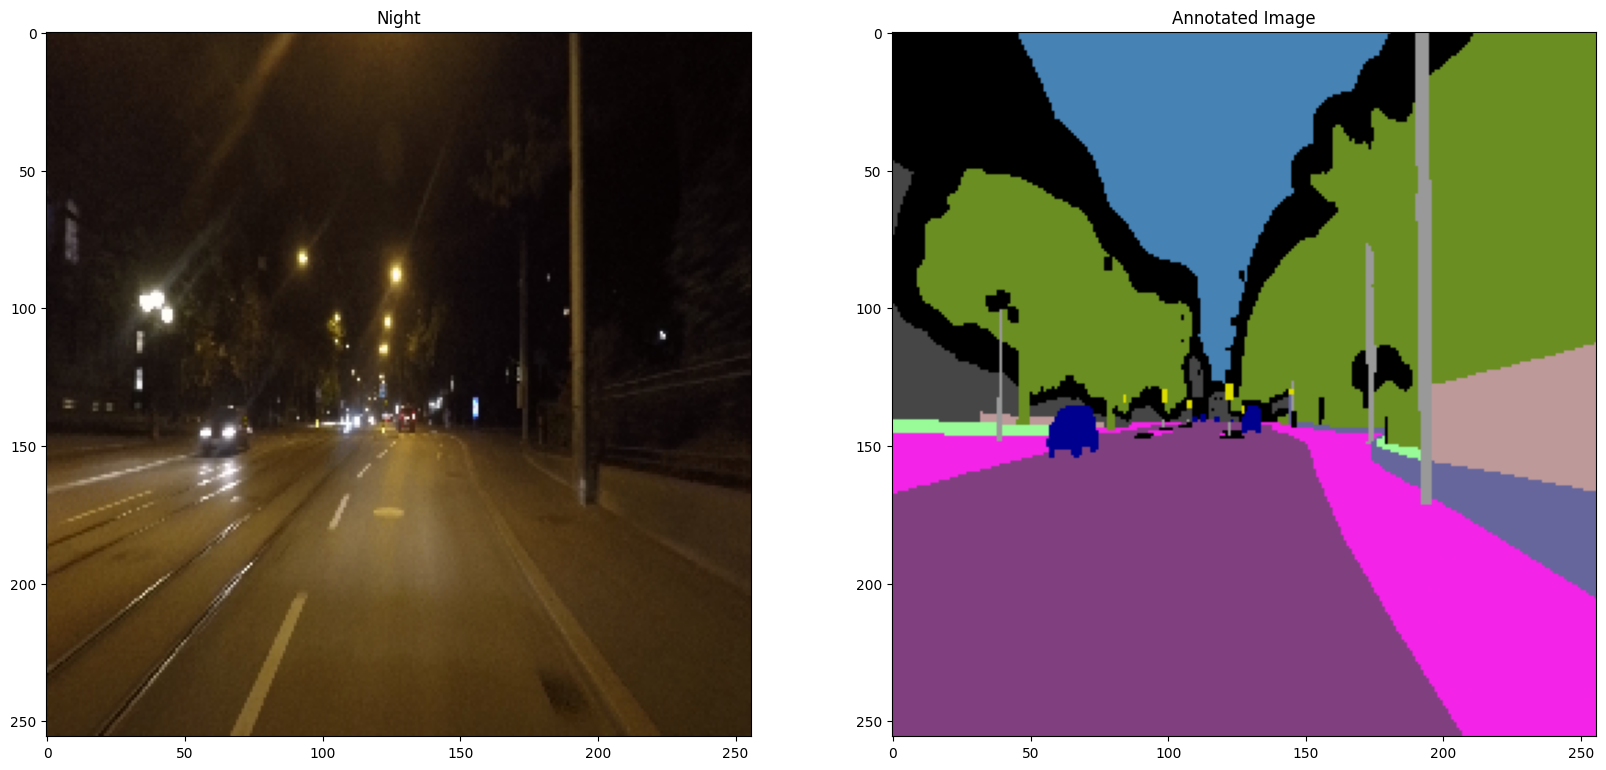

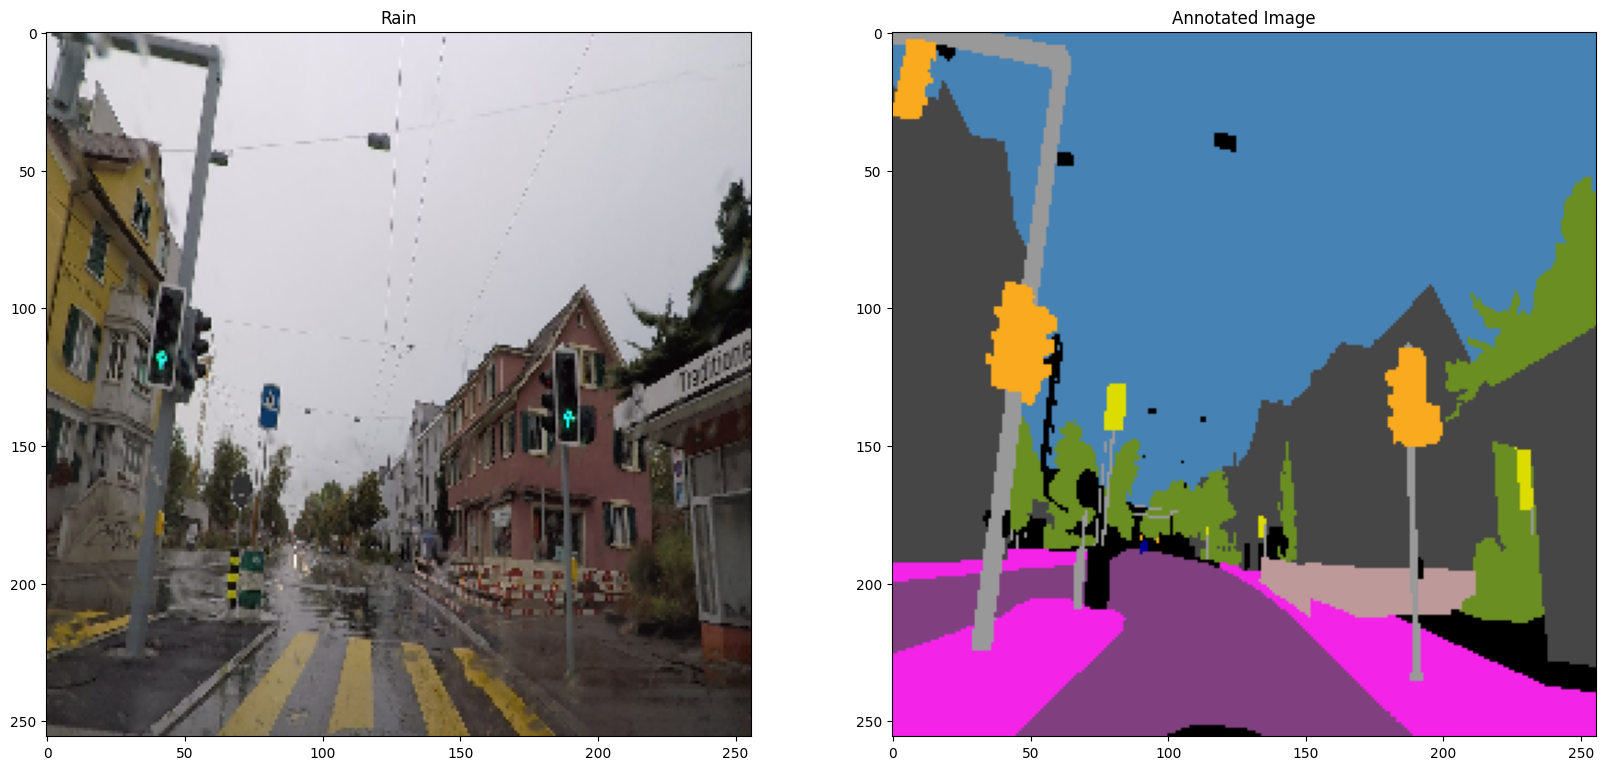

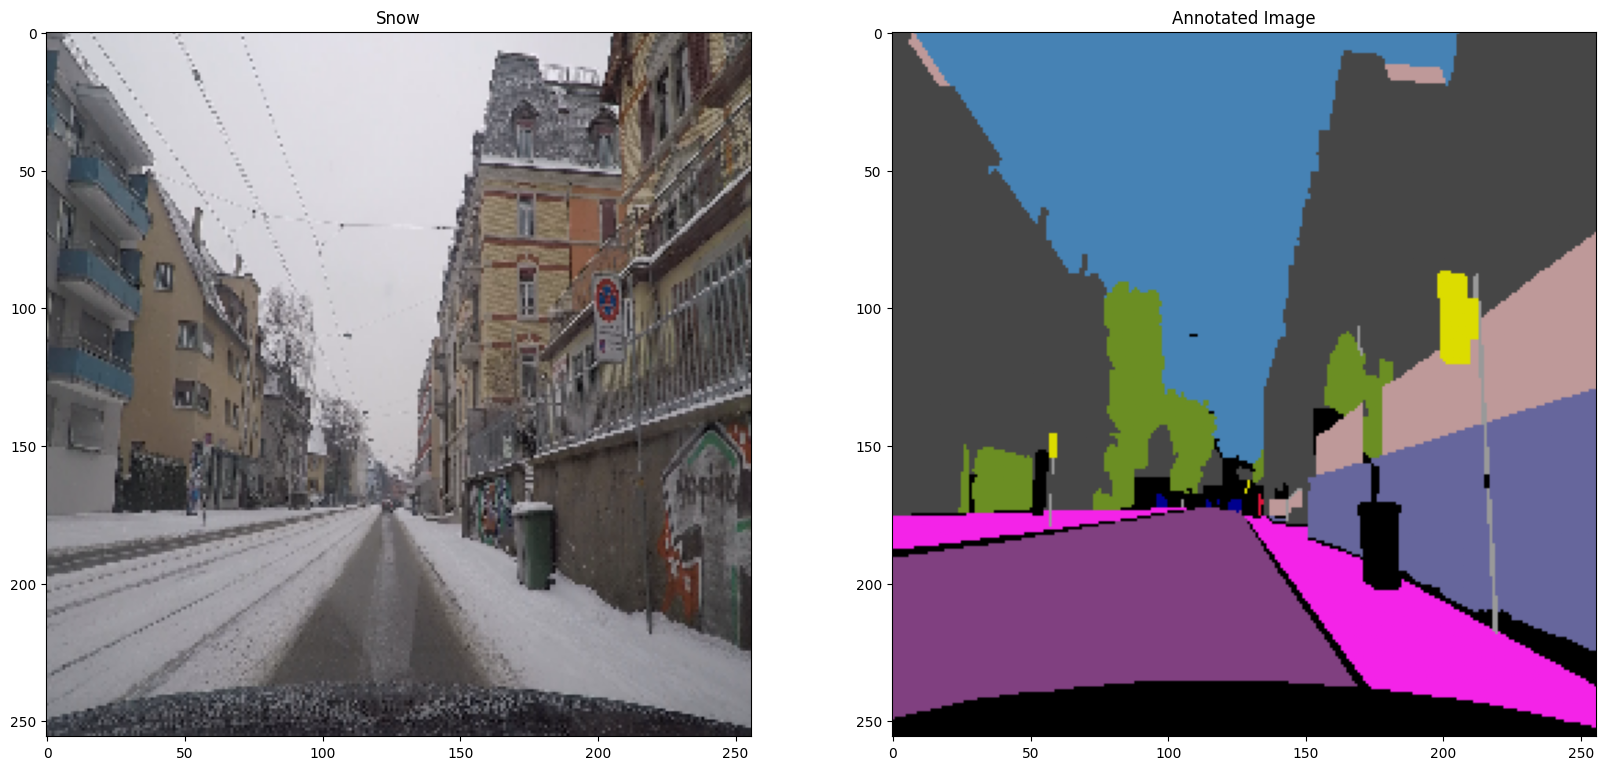

In [17]:
# Displays some images
# The RGB image with the corresponding ANNOTATED image should be correct

# Selects some images from the list of tuples
pictures = [fog_training_duo[6], night_training_duo[2], rain_training_duo[8], snow_training_duo[12],
           fog_validation_duo[15], night_validation_duo[23], rain_validation_duo[21], snow_validation_duo[20]]

def show_sample(image, annotated_image, name):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figheight(20)
    fig.set_figwidth(20)
    ax1.set_title(name)
    ax1.imshow(image / 255.)
    ax2.set_title('Annotated Image')
    ax2.imshow(annotated_image / 255.)

count = 1

# Loop to print images in the order conditions from pictures: fog -> night -> rain -> snow
for x in pictures:
    image = img_to_array(load_img(x[0], target_size=image_size))
    annotated_image = img_to_array(load_img(x[1], target_size =image_size))
    if count == 1:
        show_sample(image, annotated_image, 'Fog')
    elif count == 2:
        show_sample(image, annotated_image, 'Night')
    elif count == 3:
        show_sample(image, annotated_image, 'Rain')
    else:
        show_sample(image, annotated_image, 'Snow')
    if count == 4:
        count = 1
    else:
        count += 1

In [21]:
# Loads list of classes with an array of RGB values -> [[R, G, B], [...,...,...], ...]
classes_df = pd.read_csv(classes_csv_path)
classes = []
class_labels = []

for index, item in classes_df.iterrows():
    classes.append(np.array([item['r'], item['g'], item['b']]))
    class_labels.append(item['name'])

num_classes = len(classes)

print('Number of Classes: ' + str(num_classes))
for x in classes:
    print(x)

Number of Classes: 20
[0 0 0]
[128  64 128]
[244  35 232]
[70 70 70]
[102 102 156]
[190 153 153]
[153 153 153]
[250 170  30]
[220 220   0]
[107 142  35]
[152 251 152]
[ 70 130 180]
[220  20  60]
[255   0   0]
[  0   0 142]
[ 0  0 70]
[  0  60 100]
[  0  80 100]
[  0   0 230]
[119  11  32]


In [22]:
# U-Net model class

class UNet:
    def __init__(self, dimensions, channels, filters, n_classes):
        input_layer = Input(shape=(dimensions + (channels,)), name='input')

        conv_1_layer = self.__gen_convolution(input_layer, filters)
        conv_1_pooling = MaxPooling2D(pool_size=(2, 2))(conv_1_layer)

        conv_2_layer = self.__gen_convolution(conv_1_pooling, filters * 2)
        conv_2_pooling = MaxPooling2D(pool_size=(2, 2))(conv_2_layer)

        conv_3_layer = self.__gen_convolution(conv_2_pooling, filters * 4)
        conv_3_pooling = MaxPooling2D(pool_size=(2, 2))(conv_3_layer)

        conv_4_layer = self.__gen_convolution(conv_3_pooling, filters * 8)
        conv_4_pooling = MaxPooling2D(pool_size=(2, 2))(conv_4_layer)
        conv_4_dropout = Dropout(0.5)(conv_4_pooling)

        conv_5_layer = self.__gen_convolution(conv_4_dropout, filters * 16)
        conv_5_dropout = Dropout(0.5)(conv_5_layer)

        deconv_6_layer = self.__gen_deconvolution(conv_5_dropout, filters * 8, conv_4_layer)
        deconv_6_dropout = Dropout(0.5)(deconv_6_layer)

        deconv_7_layer = self.__gen_deconvolution(deconv_6_dropout, filters * 4, conv_3_layer)
        deconv_7_dropout = Dropout(0.5)(deconv_7_layer)

        deconv_8_layer = self.__gen_deconvolution(deconv_7_dropout, filters * 2, conv_2_layer)
        deconv_8_dropout = Dropout(0.5)(deconv_8_layer)
        
        deconv_9_layer = self.__gen_deconvolution(deconv_8_dropout, filters * 2, conv_1_layer)
        deconv_9_dropout = Dropout(0.5)(deconv_9_layer)
        
        output_layer = Conv2D(filters=n_classes, kernel_size=(1, 1), activation='softmax')(deconv_9_dropout)

        self.model = Model(inputs=input_layer, outputs=output_layer, name='UNet')

    def __gen_convolution(self, prev, filters):
        temp = Conv2D(filters=filters, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal',
                         activation='relu')(prev)
        temp = BatchNormalization()(temp)
        temp = Conv2D(filters=filters, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal',
                         activation='relu')(temp)
        return BatchNormalization()(temp)

    def __gen_deconvolution(self, prev, filters, residual):
        temp = Conv2DTranspose(filters=filters, kernel_size=(3, 3), strides=(2, 2), padding='same')(prev)
        temp = concatenate([temp, residual], axis=3)
        return self.__gen_convolution(temp, filters)

In [28]:
# Converts annotations from RGB to 2D -> Array of size image_size x image_size which contains each pixel -> Each pixel will hold a class value
def rgb_to_2D_classes(annotated, class_map):
    label = np.zeros(annotated.shape[:2], dtype=np.uint8)
    for i, rgb in enumerate(class_map):
        label[(annotated == rgb).all(axis=2)] = i
    return label

# https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
class DataGenerator(Sequence):
    'Generates data for Keras'

    def __init__(self, duo, classes, n_classes, condition, batch_size=4, dim=(128, 128), shuffle=True, train_set = False):
        'Initialization'
        self.dim = dim
        self.duo = duo
        self.classes = classes
        self.n_classes = n_classes
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.condition = condition
        self.train_set = train_set
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.duo) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Find list of IDs
        list_IDs_temp = [k for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.duo))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples'  # X : (n_samples, *dim, n_channels)
        # Initialization
        X = []
        y = []

        # Generate data
        # Could use albumentations library for augmentations (see below cell)
        for i in list_IDs_temp:
            # Store sample
            original_image = load_img(self.duo[i][0], target_size=self.dim)
            img = img_to_array(original_image) / 255. # Image to numpy array -> / 255. to get array values between 0 and 1
            X.append(img)
            if self.train_set:
                img2 = np.fliplr(img)
                X.append(img2)
            
            label = load_img(self.duo[i][1], target_size=self.dim)
            label = img_to_array(label)
            if self.train_set:
                label2 = np.fliplr(label)
                label2 = rgb_to_2D_classes(label2, self.classes)
                label2 = to_categorical(label2, num_classes=self.n_classes)
            label = rgb_to_2D_classes(label, self.classes)
            label = to_categorical(label, num_classes=self.n_classes) # Converts to binary class matrix
            y.append(label)
            if self.train_set:
                y.append(label2)
            
            if self.train_set and self.condition != 'fog':
                # Additional augmentations to prevent overfitting
                if self.condition == 'rain': 
                    temp = original_image.filter(ImageFilter.GaussianBlur(radius = 5)) # Blur
                    X.append(temp)
                    y.append(label)
                elif self.condition == 'snow':
                    temp = original_image
                    for i in range( round(temp.size[0]*temp.size[1]/5) ): # Noise
                        temp.putpixel(
                        (random.randint(0, temp.size[0]-1), random.randint(0, temp.size[1]-1)),
                        (random.randint(0,255),random.randint(0,255),random.randint(0,255))
                        )
                    X.append(temp)
                    y.append(label)
                elif self.condition == 'night':
                    temp = ImageEnhance.Brightness(original_image) # Lighter
                    temp = temp.enhance(2.0)
                    temp = img_to_array(temp) / 255.
                    X.append(temp)
                    y.append(label)
                
        return np.array(X), np.array(y)

In [ ]:
# Data Generator using the albumentations library, contains alot of useful augmentations prebuilt
# Code needs a little tweaking
# https://albumentations.ai/

# from albumentations import (
#     RandomSnow, RandomRain, RandomBrightnessContrast, CLAHE, ShiftScaleRotate,
#     Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, GaussianBlur,
#     GaussNoise, MotionBlur, MedianBlur, PiecewiseAffine,
#     RandomFog, Emboss, RandomBrightnessContrast, Flip, OneOf, Compose
# )

# def strong_aug(p=0.3):
#     return Compose([
#         Flip(p=0.5),
#         OneOf([
#             RandomBrightnessContrast(),
#         ], p=0.5),
#         ShiftScaleRotate(p=0.3),
#         GaussianBlur(p=0.3)
#     ], p=p,
#     additional_targets={"image2" : "image"})

# # Converts annotations from RGB to 2D -> Array of size image_size x image_size which contains each pixel -> Each pixel will hold a class value
# def rgb_to_2D_classes(annotated, class_map):
#     label = np.zeros(annotated.shape[:2], dtype=np.uint8)
#     for i, rgb in enumerate(class_map):
#         label[(annotated == rgb).all(axis=2)] = i
#     return label

# # https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
# class DataGenerator_TRAIN(Sequence):
#     'Generates data for Keras'

#     def __init__(self, duo, classes, n_classes, batch_size=4, dim=(128, 128), shuffle=True):
#         'Initialization'
#         self.dim = dim
#         self.duo = duo
#         self.classes = classes
#         self.n_classes = n_classes
#         self.batch_size = batch_size
#         self.shuffle = shuffle
#         self.on_epoch_end()

#     def __len__(self):
#         'Denotes the number of batches per epoch'
#         return int(np.floor(len(self.duo) / self.batch_size))

#     def __getitem__(self, index):
#         'Generate one batch of data'
#         # Generate indexes of the batch
#         indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

#         # Find list of IDs
#         list_IDs_temp = [k for k in indexes]

#         # Generate data
#         X, y = self.__data_generation(list_IDs_temp)

#         return X, y

#     def on_epoch_end(self):
#         'Updates indexes after each epoch'
#         self.indexes = np.arange(len(self.duo))
#         if self.shuffle == True:
#             np.random.shuffle(self.indexes)

#     def __data_generation(self, list_IDs_temp):
#         'Generates data containing batch_size samples'  # X : (n_samples, *dim, n_channels)
#         # Initialization
#         X = []
#         y = []

#         # Generate data
#         for i in list_IDs_temp:
#             # Store sample
#             img = load_img(self.duo[i][0], target_size=self.dim)
#             img = img_to_array(img)# Image to numpy array -> / 255. to get array values between 0 and 1

#             label = load_img(self.duo[i][1], target_size=self.dim)
#             label = img_to_array(label)
            
#             image1 = img.astype(np.uint8)
#             image2 = label.astype(np.uint8)
#             aug_input = {"image" : image1, "image2" : image2}
#             aug = strong_aug(0.5)
#             augmented_data = aug(**aug_input)
#             i1 = augmented_data["image"] / 255.
#             i2 = augmented_data["image2"]
            
#             i2 = rgb_to_2D_classes(i2, self.classes)
#             i2 = to_categorical(i2, num_classes=self.n_classes) # Converts to binary class matrix
#             X.append(i1)
#             y.append(i2)

#         return np.array(X), np.array(y)

In [29]:
#fog_model = keras.models.load_model("E:/Model To Pre-Train/saved_model") -> Load previous model

# Creates NEW U-Net model
fog_model = UNet(image_size, 3, 64, num_classes).model

# Used to unfreeze some layers
#for idx, x in enumerate(fog_model.layers[0].layers):
#    if 'conv' in x.name and idx > 28:
#        x.trainable = True

fog_model.compile(optimizer='adamax', loss='categorical_crossentropy' ,metrics=['accuracy', keras.metrics.OneHotMeanIoU(num_classes=num_classes)])

fog_my_callbacks = [
    CSVLogger("./fog/logs/log.csv", separator=",", append=False),
    ModelCheckpoint(filepath='./fog/fog-weights.h5', save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True),
    TensorBoard(log_dir='./fog/logs')
]

fog_training_data = DataGenerator(fog_training_duo,classes,num_classes,batch_size=3, dim=image_size ,shuffle=True, condition='fog', train_set=True)
fog_training_steps = fog_training_data.__len__()

fog_validation_data = DataGenerator(fog_validation_duo,classes,num_classes,batch_size=3, dim=image_size ,shuffle=True, condition='fog')
fog_validation_steps = fog_validation_data.__len__()

fog_model.summary()

Model: "UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 256, 256, 64  1792        ['input[0][0]']                  
                                )                                                                 
                                                                                                  
 batch_normalization_36 (BatchN  (None, 256, 256, 64  256        ['conv2d_38[0][0]']              
 ormalization)                  )                                                              

                                                                                                  
 conv2d_48 (Conv2D)             (None, 32, 32, 512)  4719104     ['concatenate_8[0][0]']          
                                                                                                  
 batch_normalization_46 (BatchN  (None, 32, 32, 512)  2048       ['conv2d_48[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_49 (Conv2D)             (None, 32, 32, 512)  2359808     ['batch_normalization_46[0][0]'] 
                                                                                                  
 batch_normalization_47 (BatchN  (None, 32, 32, 512)  2048       ['conv2d_49[0][0]']              
 ormalization)                                                                                    
          

In [30]:
fog_model_train = fog_model.fit(fog_training_data, epochs=100, callbacks=fog_my_callbacks, validation_data=fog_validation_data, steps_per_epoch=fog_training_steps, validation_steps=fog_validation_steps)

Epoch 1/100


2023-07-04 00:23:12.403102: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-07-04 00:23:13.880035: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inUNet/dropout_12/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-07-04 00:23:15.858024: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-07-04 00:23:18.025908: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-07-04 00:23:18.044926: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x355fd830 initializ

133/133 [==============================] - ETA: 0s - loss: 1.1380 - accuracy: 0.6900 - one_hot_mean_io_u_2: 0.1412

2023-07-04 00:24:22.046837: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


133/133 [==============================] - 76s 488ms/step - loss: 1.1380 - accuracy: 0.6900 - one_hot_mean_io_u_2: 0.1412 - val_loss: 3.1071 - val_accuracy: 0.4700 - val_one_hot_mean_io_u_2: 0.0736
Epoch 2/100
133/133 [==============================] - 50s 373ms/step - loss: 0.8408 - accuracy: 0.7582 - one_hot_mean_io_u_2: 0.1887 - val_loss: 1.5061 - val_accuracy: 0.6052 - val_one_hot_mean_io_u_2: 0.1054
Epoch 3/100
133/133 [==============================] - 50s 374ms/step - loss: 0.7544 - accuracy: 0.7827 - one_hot_mean_io_u_2: 0.2151 - val_loss: 1.1508 - val_accuracy: 0.6099 - val_one_hot_mean_io_u_2: 0.1262
Epoch 4/100
133/133 [==============================] - 48s 361ms/step - loss: 0.7028 - accuracy: 0.7974 - one_hot_mean_io_u_2: 0.2278 - val_loss: 0.7814 - val_accuracy: 0.7560 - val_one_hot_mean_io_u_2: 0.1908
Epoch 5/100
133/133 [==============================] - 49s 368ms/step - loss: 0.6433 - accuracy: 0.8128 - one_hot_mean_io_u_2: 0.2420 - val_loss: 0.6231 - val_accuracy: 0.8

KeyboardInterrupt: 

In [27]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger, TensorBoard

night_model = UNet(image_size, 3, 64, num_classes).model

night_model.compile(optimizer='adamax', loss='categorical_crossentropy' ,metrics=['accuracy', keras.metrics.OneHotMeanIoU(num_classes=num_classes)])

night_my_callbacks = [
    CSVLogger("./night/logs/log.csv", separator=",", append=False),
    ModelCheckpoint(filepath='./night/night-weights.h5', save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True),
    TensorBoard(log_dir='./night/logs')
]

night_training_data = DataGenerator(night_training_duo,classes,num_classes,batch_size=3, dim=image_size ,shuffle=True, condition='night', train_set=True)
night_training_steps = night_training_data.__len__()

night_validation_data = DataGenerator(night_validation_duo,classes,num_classes,batch_size=3, dim=image_size ,shuffle=True, condition='night')
night_validation_steps = night_validation_data.__len__()

night_model_train = night_model.fit(night_training_data, epochs=300, callbacks=night_my_callbacks, validation_data=night_validation_data, steps_per_epoch=night_training_steps, validation_steps=night_validation_steps)

Epoch 1/300
133/133 [==============================] - 291s 2s/step - loss: 1.8061 - accuracy: 0.4898 - one_hot_mean_io_u_5: 0.0856 - val_loss: 39.8252 - val_accuracy: 0.3047 - val_one_hot_mean_io_u_5: 0.0235
Epoch 2/300
133/133 [==============================] - 303s 2s/step - loss: 1.3441 - accuracy: 0.5782 - one_hot_mean_io_u_5: 0.1158 - val_loss: 11.4789 - val_accuracy: 0.3036 - val_one_hot_mean_io_u_5: 0.0264
Epoch 3/300
133/133 [==============================] - 303s 2s/step - loss: 1.2106 - accuracy: 0.6056 - one_hot_mean_io_u_5: 0.1309 - val_loss: 1.4196 - val_accuracy: 0.5263 - val_one_hot_mean_io_u_5: 0.1138
Epoch 4/300
133/133 [==============================] - 300s 2s/step - loss: 1.1405 - accuracy: 0.6257 - one_hot_mean_io_u_5: 0.1411 - val_loss: 1.1174 - val_accuracy: 0.6048 - val_one_hot_mean_io_u_5: 0.1383
Epoch 5/300
133/133 [==============================] - 299s 2s/step - loss: 1.0659 - accuracy: 0.6463 - one_hot_mean_io_u_5: 0.1544 - val_loss: 1.3420 - val_accuracy:

KeyboardInterrupt: 

In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger, TensorBoard

rain_model = UNet(image_size, 3, 64, num_classes).model

rain_model.compile(optimizer='adamax', loss='categorical_crossentropy' ,metrics=['accuracy', keras.metrics.OneHotMeanIoU(num_classes=num_classes)])

rain_my_callbacks = [
    CSVLogger("./rain/logs/log.csv", separator=",", append=False),
    ModelCheckpoint(filepath='./rain/rain-weights.h5', save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True),
    TensorBoard(log_dir='./rain/logs')
]

rain_training_data = DataGenerator(rain_training_duo,classes,num_classes,batch_size=3, dim=image_size ,shuffle=True, condition='rain', train_set=True)
rain_training_steps = rain_training_data.__len__()

rain_validation_data = DataGenerator(rain_validation_duo,classes,num_classes,batch_size=3, dim=image_size ,shuffle=True, condition='rain')
rain_validation_steps = rain_validation_data.__len__()

rain_model_train = rain_model.fit(rain_training_data, epochs=300, callbacks=rain_my_callbacks, validation_data=rain_validation_data, steps_per_epoch=rain_training_steps, validation_steps=rain_validation_steps)

In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger, TensorBoard

snow_model = UNet(image_size, 3, 64, num_classes).model

snow_model.compile(optimizer='adamax', loss='categorical_crossentropy' ,metrics=['accuracy', keras.metrics.OneHotMeanIoU(num_classes=num_classes)])

snow_my_callbacks = [
    CSVLogger("./snow/logs/log.csv", separator=",", append=False),
    ModelCheckpoint(filepath='./snow/snow-weights.h5', save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True),
    TensorBoard(log_dir='./snow/logs')
]

snow_training_data = DataGenerator(snow_training_duo,classes,num_classes,batch_size=3, dim=image_size ,shuffle=True, condition='snow', train_set=True)
snow_training_steps = snow_training_data.__len__()

snow_validation_data = DataGenerator(snow_validation_duo,classes,num_classes,batch_size=3, dim=image_size ,shuffle=True, condition='snow')
snow_validation_steps = snow_validation_data.__len__()

snow_model_train = snow_model.fit(snow_training_data, epochs=300, callbacks=snow_my_callbacks, validation_data=snow_validation_data, steps_per_epoch=snow_training_steps, validation_steps=snow_validation_steps)

In [ ]:
# Calulate IOU for each semantic class

def convert_to_labels(rgbto2Dclassesarray, class_labels):
    labels = []
    for x in rgbto2Dclassesarray:
        temp = []
        for arr in x:
            temp.append(class_labels[arr])
        labels.append(temp)
    return labels

# Evaluate on the validation sets
items = [fog_validation_duo, night_validation_duo, rain_validation_duo, snow_validation_duo]

models = [fog_model, night_model, rain_model, snow_model]
names = ['Fog', 'Night', 'Rain', 'Snow']

for list_idx, dataset in enumerate(items):
    mean_iou_classes = []
    mean_IOU_state = None
    for i in dataset:
        img = load_img(i[0], target_size=(256, 256)) # Get original rgb image to pass in model
        annotated_img = load_img(i[1], target_size=(256, 256)) # Annotated image from dataset
        annotated_img = img_to_array(annotated_img)
        annotated_img = rgb_to_2D_classes(annotated_img, classes) # Converts annotated image array values to the classes we have
        img_expanded = np.expand_dims(img_to_array(img) / 255., axis=0) 
        prediction = np.argmax(models[list_idx].predict(img_expanded)[0], axis=2) # Annotated prediction from model
        m_IOU = keras.metrics.MeanIoU(num_classes=num_classes)
        m_IOU.update_state(annotated_img, prediction)
        if mean_IOU_state == None:
            mean_IOU_state = m_IOU
        else:
            mean_IOU_state.merge_state([m_IOU])
        for idx, x in enumerate(classes): # Go through all classes, idx is the class
            m = keras.metrics.IoU(num_classes=num_classes, target_class_ids=[idx])
            m.update_state(annotated_img, prediction)
            iou_result = m.result().numpy() 
            if len(mean_iou_classes) <= idx:
                mean_iou_classes.append(m)
            else:
                prev = mean_iou_classes[idx]
                m.merge_state([prev])
                mean_iou_classes[idx] = m
    print(names[list_idx] + ' Mean IOU Validation:' + str(mean_IOU_state.result().numpy()))
    for idx, x in enumerate(class_labels):
        print(x + ': ' + str(mean_iou_classes[idx].result().numpy())) # print IOU for each class
    print('-----------------------')

In [28]:
fog_model.save('./fog/fog_saved_model')
night_model.save('./night/night_saved_model')
rain_model.save('./rain/rain_saved_model')
snow_model.save('./snow/snow_saved_model')

INFO:tensorflow:Assets written to: ./fog/fog_saved_model\assets


INFO:tensorflow:Assets written to: ./fog/fog_saved_model\assets


INFO:tensorflow:Assets written to: ./night/night_saved_model\assets


INFO:tensorflow:Assets written to: ./night/night_saved_model\assets


In [12]:
fog_prediction = Predict(image_size, fog_model, classes)
night_prediction = Predict(image_size, night_model, classes)
rain_prediction = Predict(image_size, rain_model, classes)
snow_prediction = Predict(image_size, snow_model, classes)

In [ ]:
for x in range(0, 1):
    fog_prediction.predict(fog_training_duo[x])
    night_prediction.predict(night_training_duo[x])
    rain_prediction.predict(rain_training_duo[x])
    snow_prediction.predict(snow_training_duo[x])

In [ ]:
for x in range(0, 1):
    fog_prediction.predict(fog_validation_duo[x])
    night_prediction.predict(night_validation_duo[x])
    rain_prediction.predict(rain_validation_duo[x])
    snow_prediction.predict(snow_validation_duo[x])